# **Importing Required Libraries**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import jaccard_score, f1_score
import os
import tensorflow as tf

np.random.seed(42)

c:\Users\varni\miniconda3\envs\myenv\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# **Gaussian Mixture Model (GMM) for Image Segmentation**

## **Function Overview**
This function applies Gaussian Mixture Model (GMM) for image segmentation. It ensures that the segmented mask has a white foreground (255) and a black background (0).


In [2]:
def segment_gmm(image, num_components=2):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    pixels = gray.reshape(-1, 1)
        
    # Fit GMM
    gmm = GaussianMixture(n_components=num_components, covariance_type="tied", random_state=42)
    gmm.fit(pixels)
    labels = gmm.predict(pixels)
    
    # Reshape back to image
    segmented = labels.reshape(gray.shape)
    
    # Assign the brighter region as mask (white)
    label0_mean = np.mean(gray[segmented == 0])
    label1_mean = np.mean(gray[segmented == 1])
    mask_label = 1 if label1_mean > label0_mean else 0
    mask = (segmented == mask_label).astype(np.uint8) * 255
    
    return mask

# **Otsu's Thresholding for Image Segmentation**    

## **Function Overview**
This function segments an image using Otsu's thresholding, which automatically determines the optimal threshold value for separating the foreground from the background.


In [3]:
def segment_otsu(image):
    """
    Segments the mask using Otsu's thresholding.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

# **Watershed Algorithm for Image Segmentation**

## **Function Overview**
This function applies the Watershed Algorithm to segment an image into foreground and background regions. Watershed is useful for separating overlapping objects.

In [4]:
def segment_watershed(image):
    """
    Segments the mask using Watershed Algorithm.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

    # Unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Apply Watershed
    image_copy = image.copy()
    cv2.watershed(image_copy, markers)
    mask = np.uint8(markers > 1) * 255  # Convert to binary mask
    
    return mask

# **Compute Segmentation Metrics: IoU and Dice Score**

## **Function Overview**
This function computes two key evaluation metrics for segmentation tasks:

IoU (Intersection over Union)

Dice Score (F1 Score for segmentation)


In [5]:
def compute_metrics(seg_mask, ground_truth):
    """
    Computes IoU (Intersection over Union) and Dice Score.
    """
    seg_mask = (seg_mask > 0).astype(np.uint8).flatten()
    ground_truth = (ground_truth > 0).astype(np.uint8).flatten()
    
    iou = jaccard_score(ground_truth, seg_mask)
    dice = f1_score(ground_truth, seg_mask)  # Dice Score = 2 * (|X ∩ Y|) / (|X| + |Y|)

    return iou, dice

# **Face Segmentation Evaluation**
This script processes images from a dataset, applies three different segmentation methods (GMM, Otsu, and Watershed), computes evaluation metrics (IoU and Dice coefficient) by comparing against ground truth masks, and displays the results with corresponding metrics. 

The code loads each image and its corresponding ground truth mask, applies the segmentation methods, calculates performance metrics, and visualizes the results in a 2x3 grid showing:
- Original image
- Ground truth mask
- GMM segmentation with metrics
- Otsu segmentation with metrics
- Watershed segmentation with metrics

In [6]:
directory = "../dataset/face_crop"
groundTruth = "../dataset/face_crop_segmentation"

image_files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
selected_indices = np.random.choice(len(image_files), 20, replace=False)
selected_images = [image_files[i] for i in selected_indices]
# selected_gt_images = np.array([os.path.join(groundTruth, f) for f in selected_images])



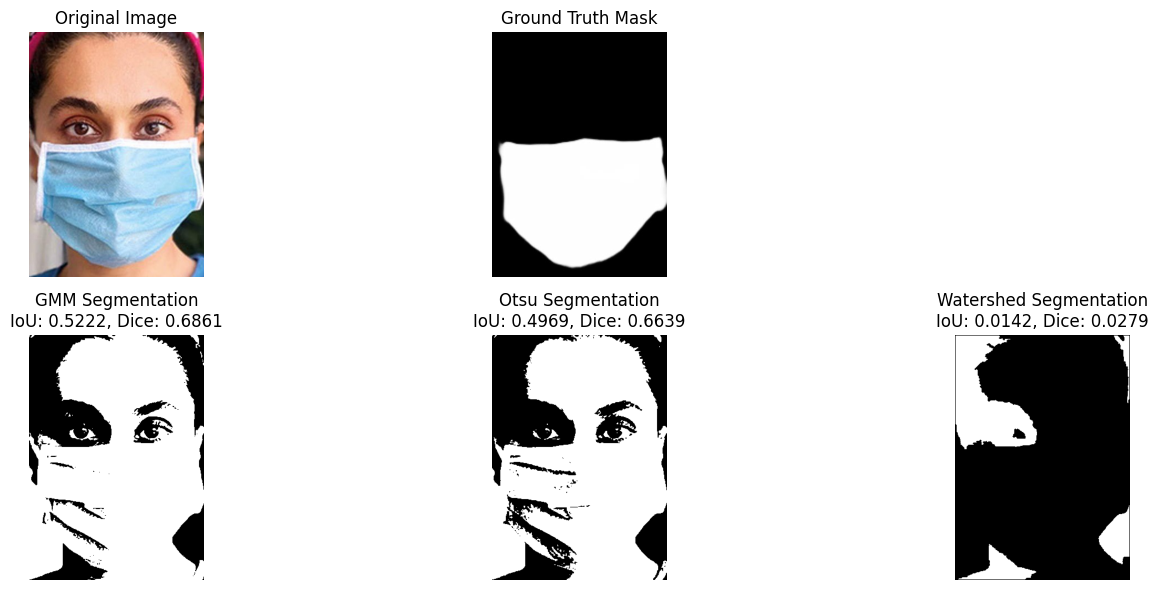

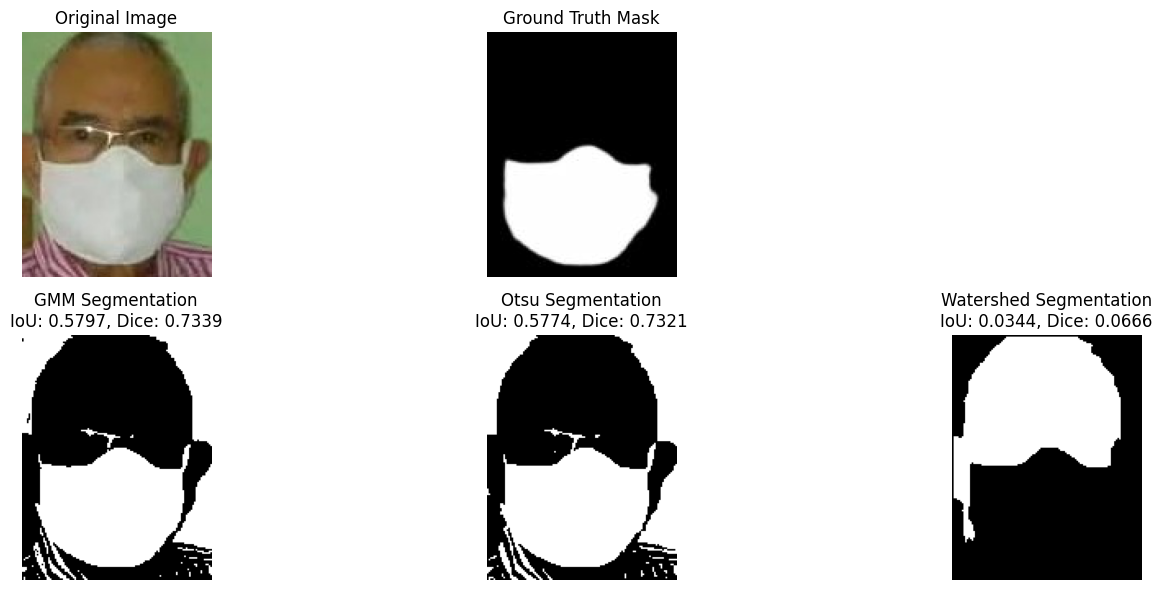

c:\Users\varni\miniconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


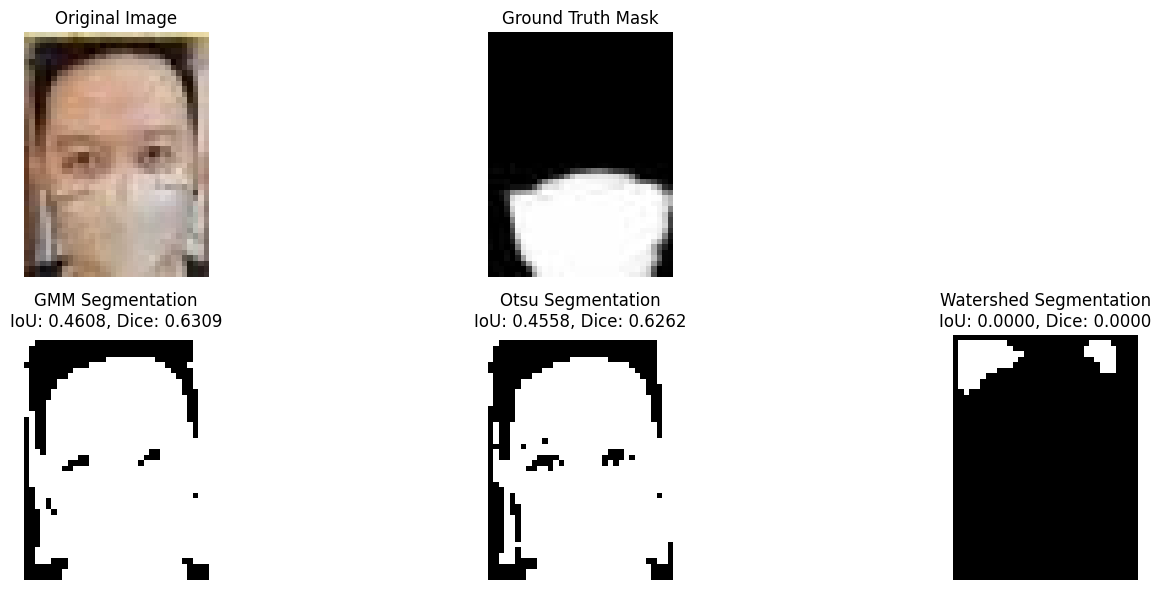

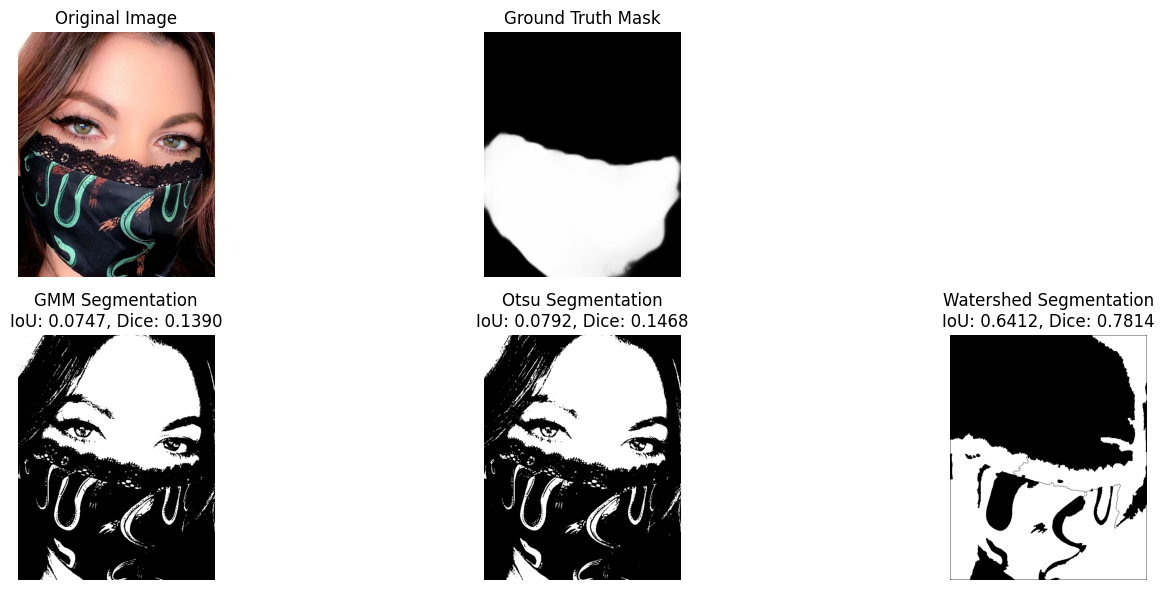

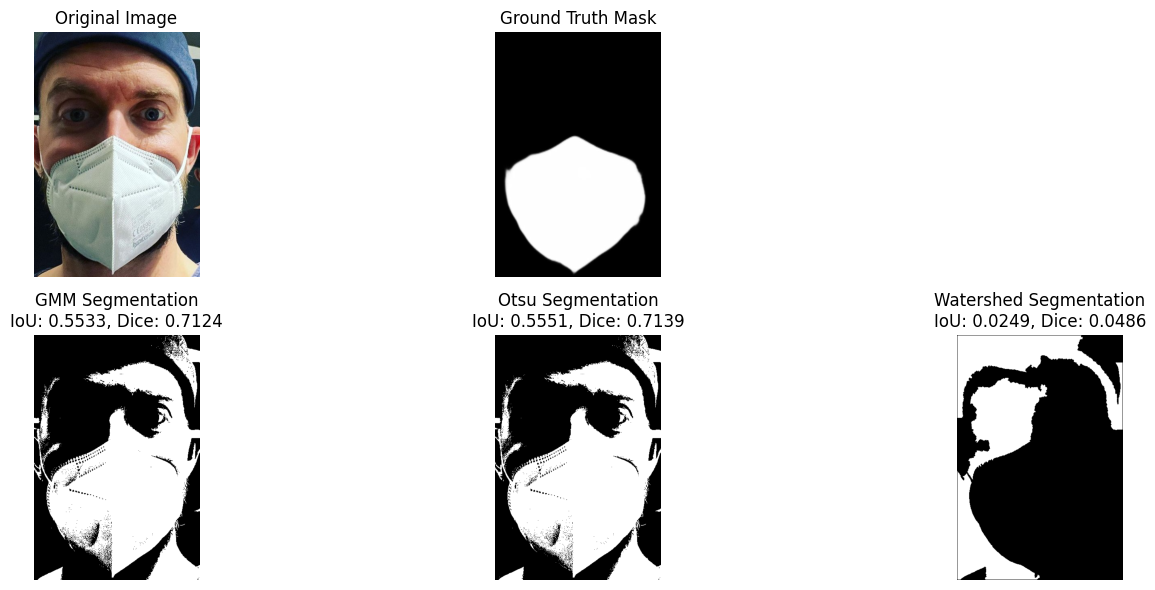

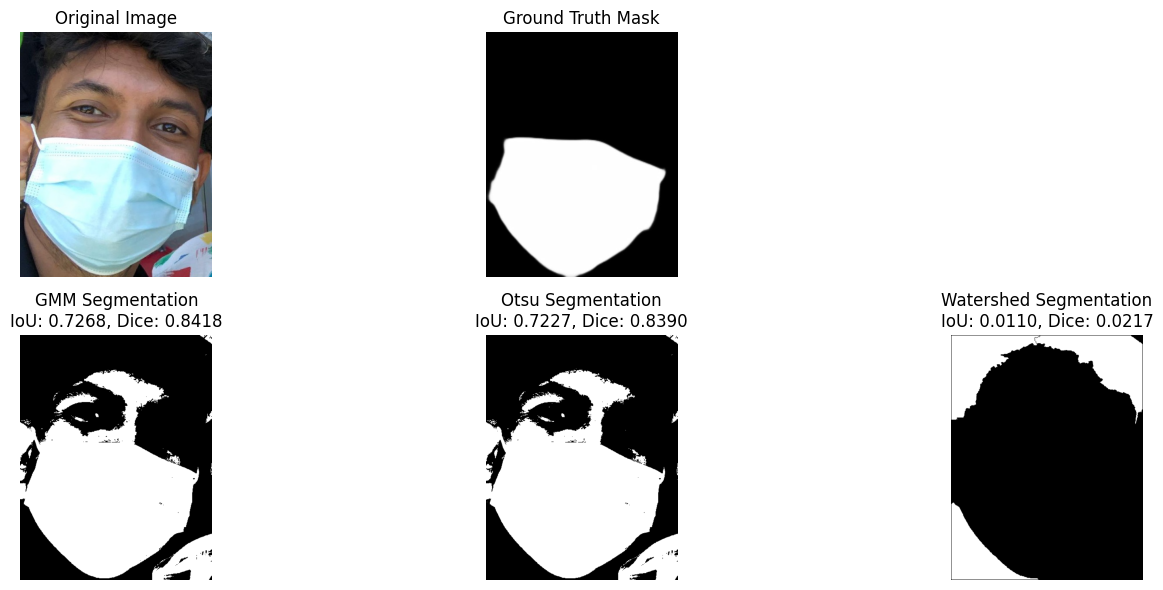

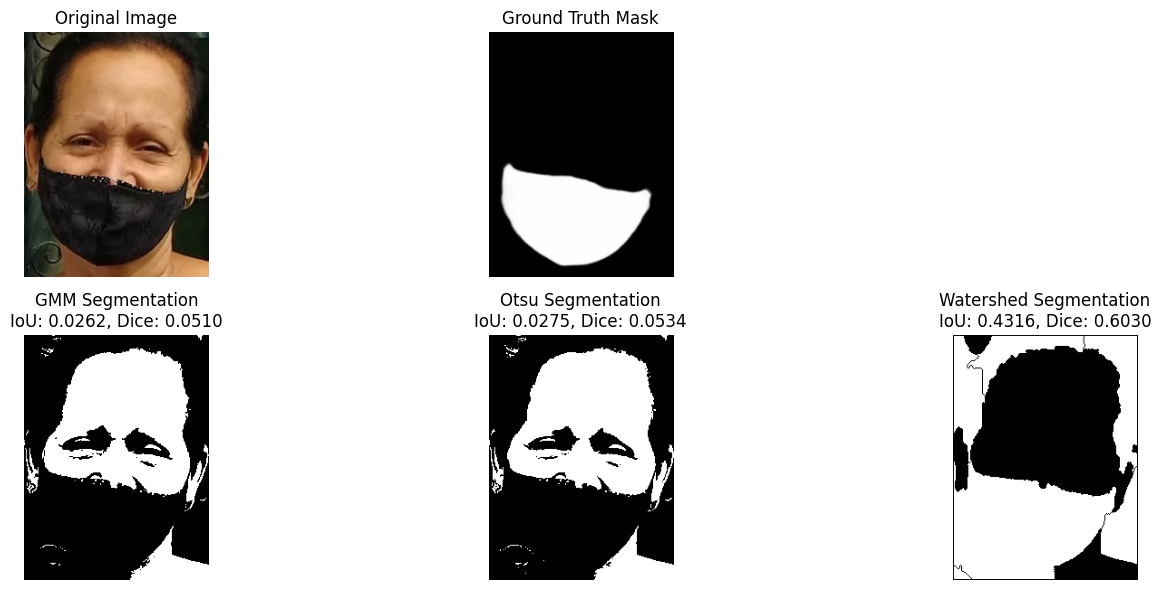

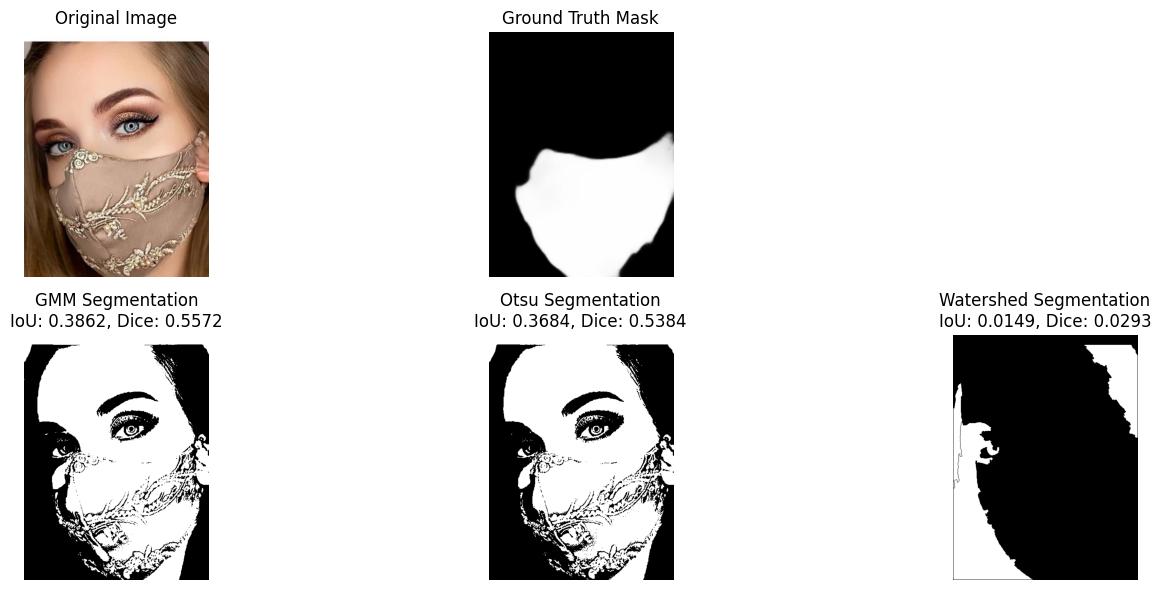

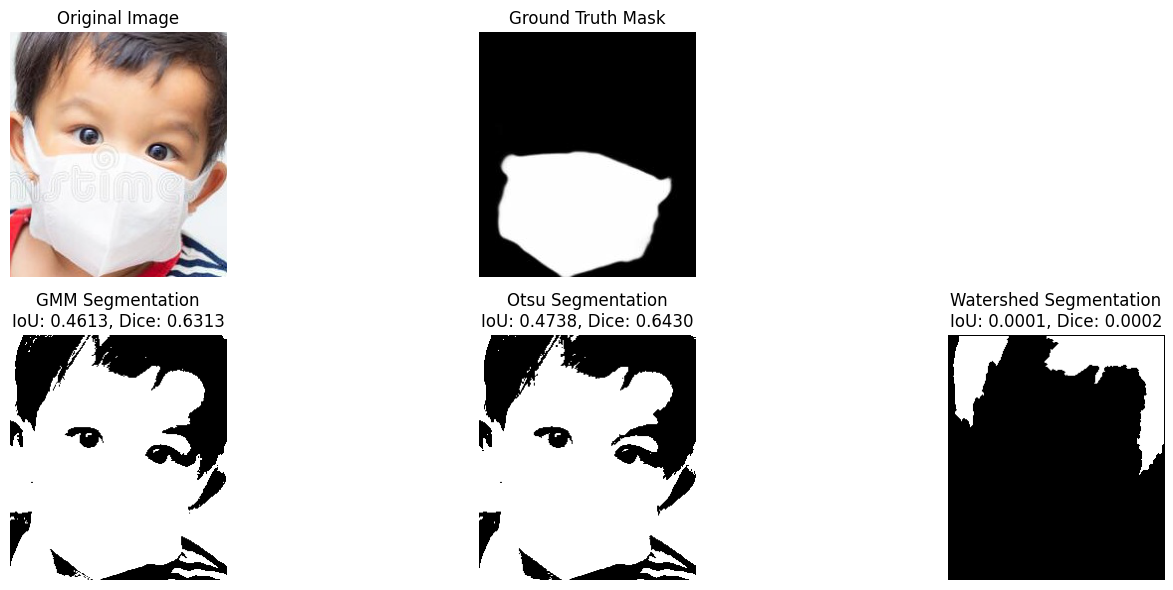

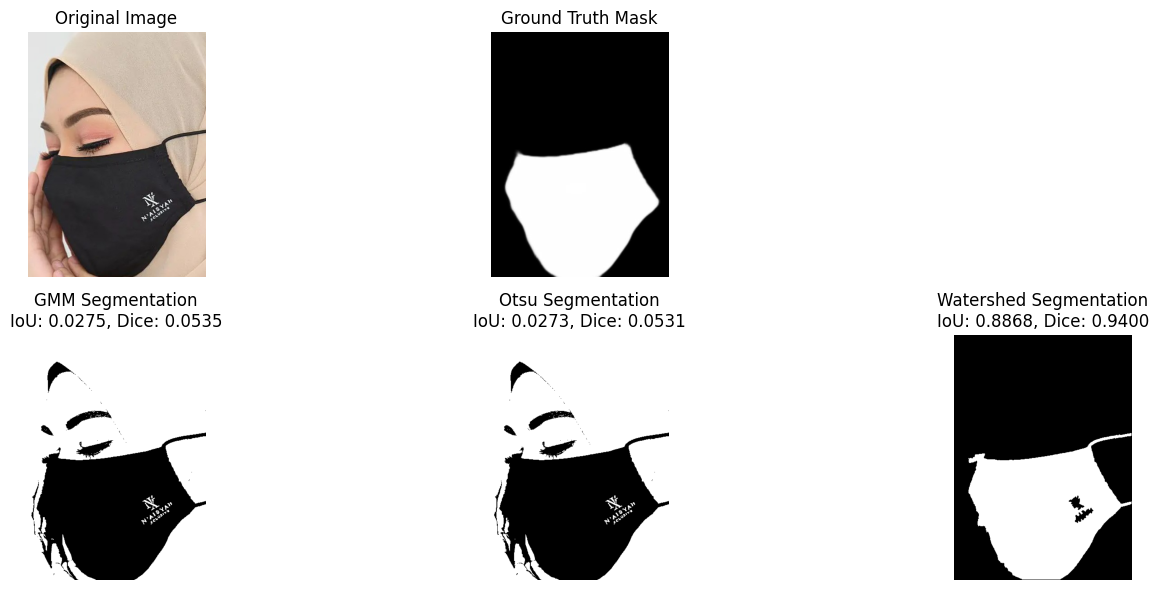

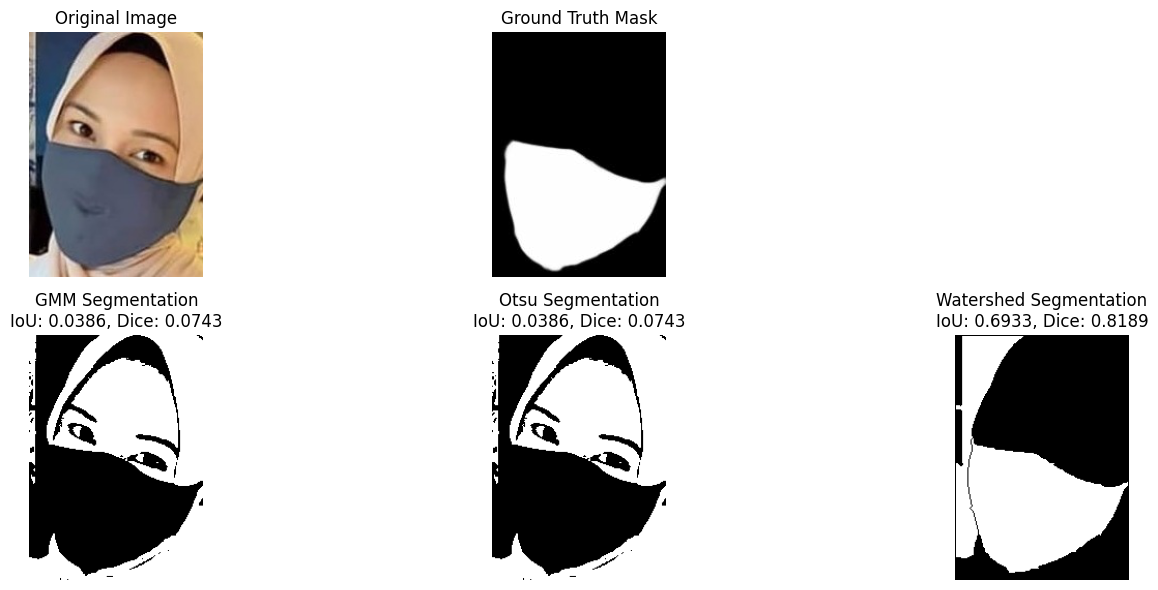

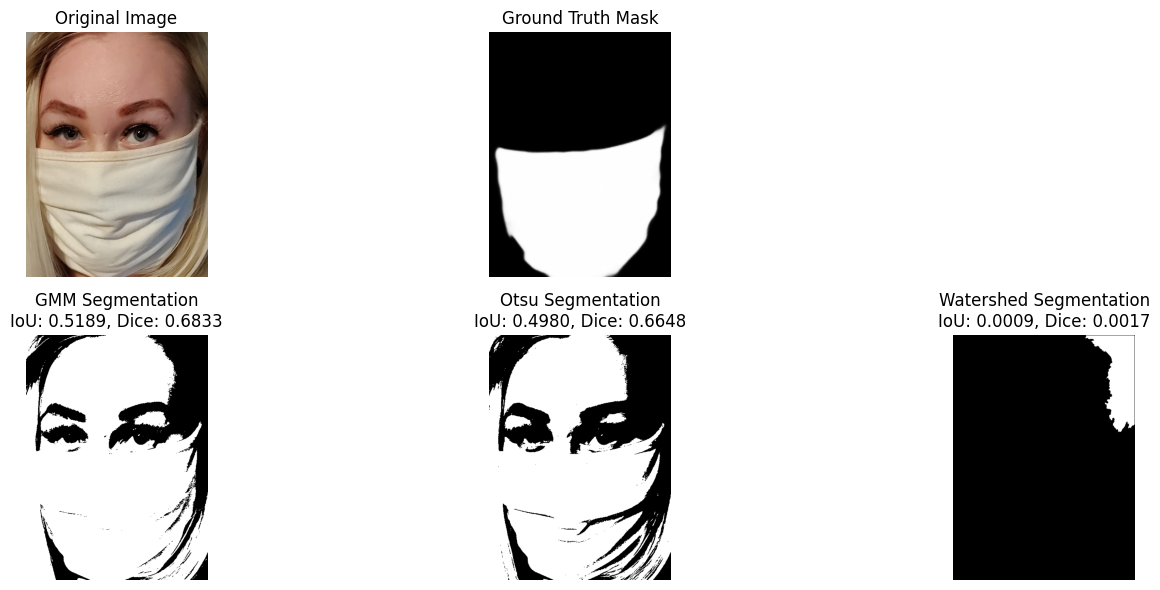

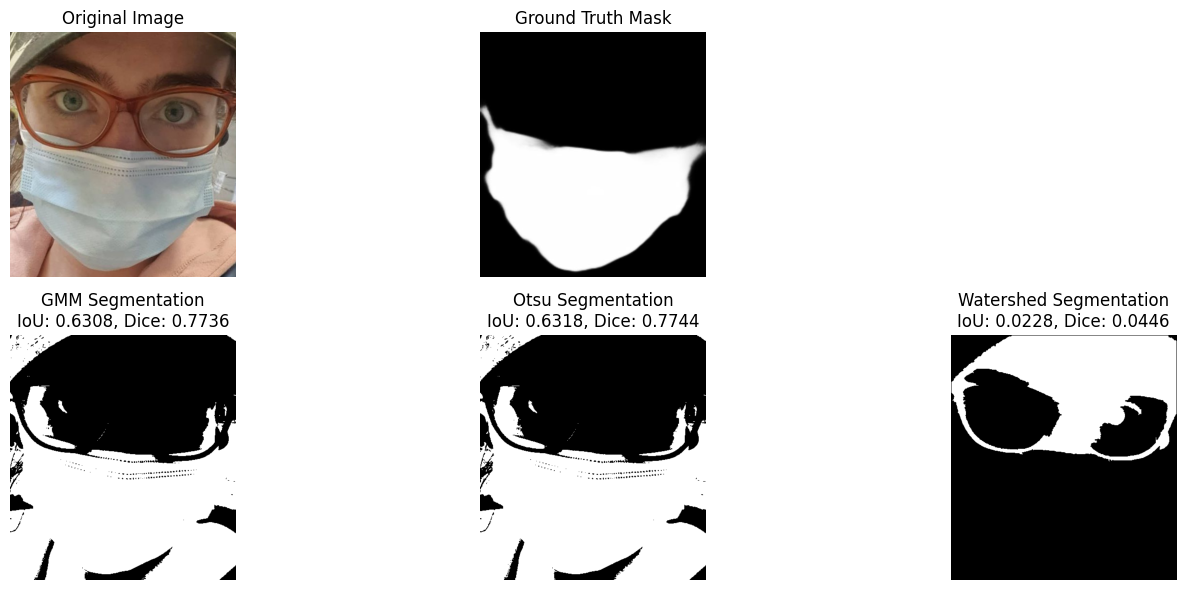

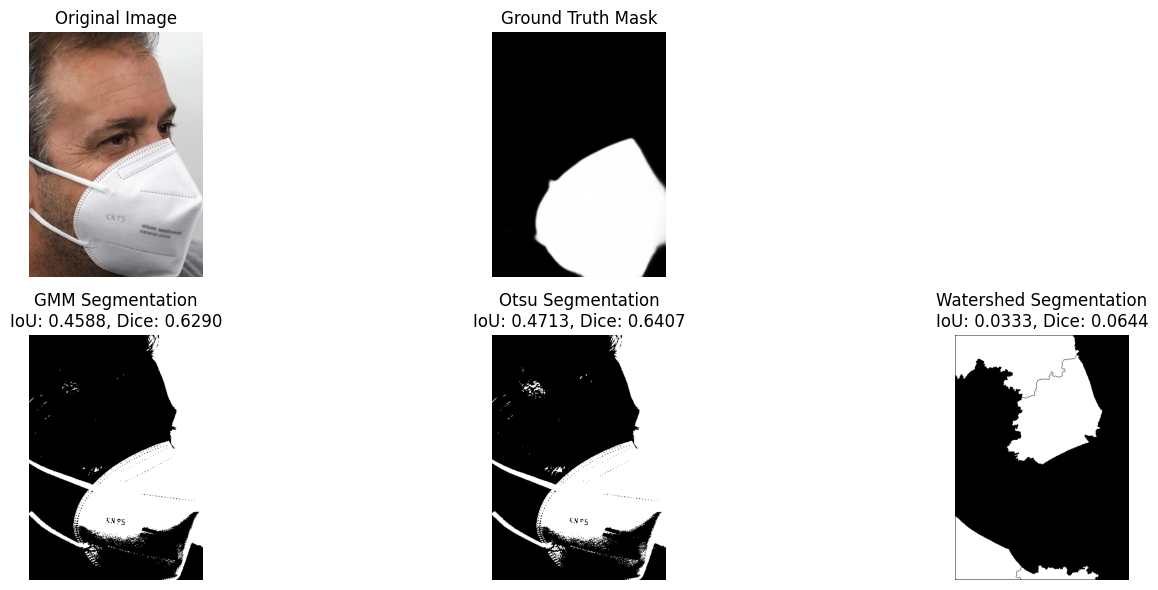

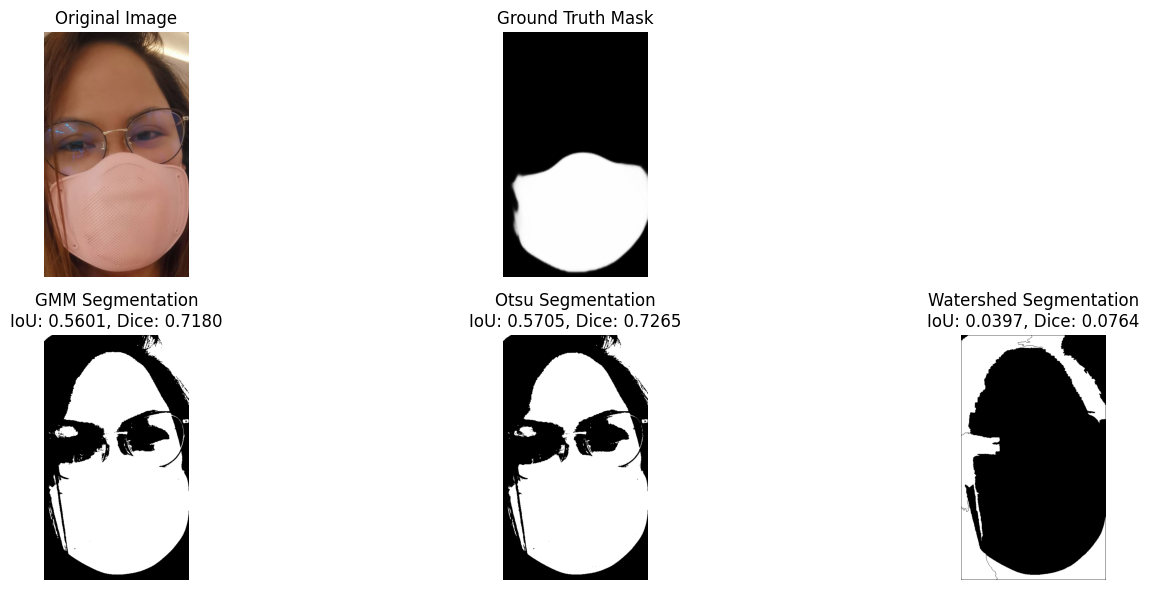

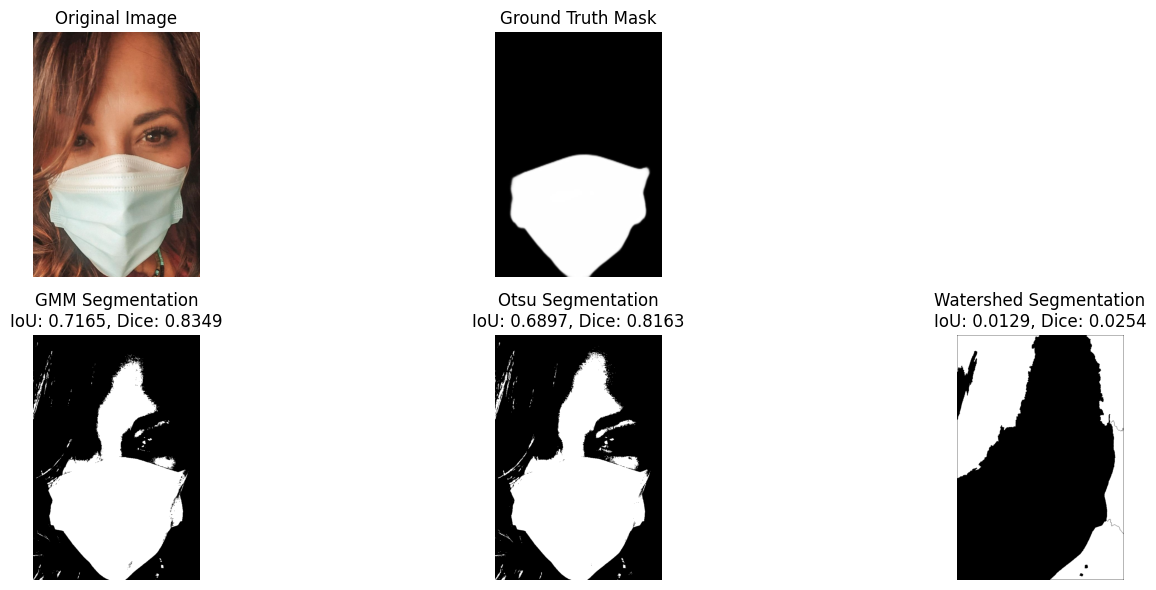

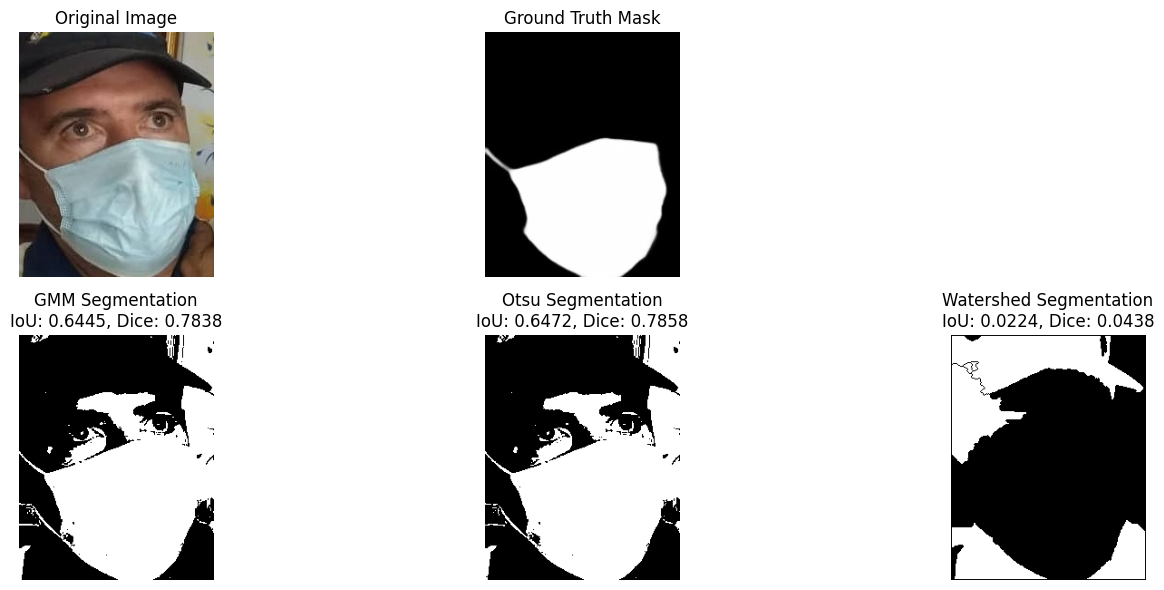

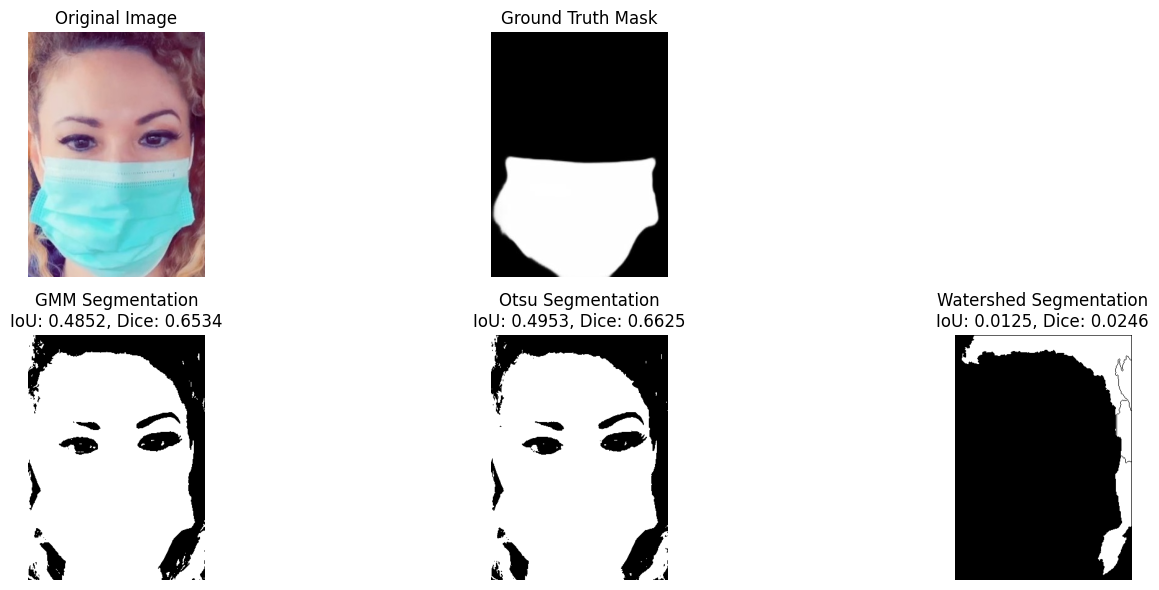

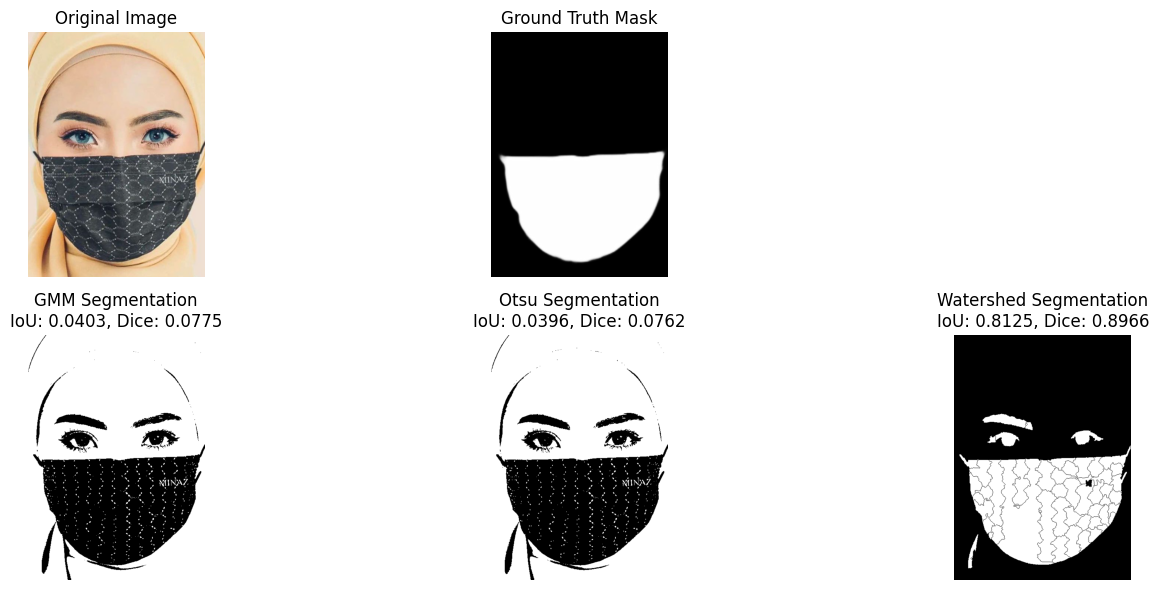

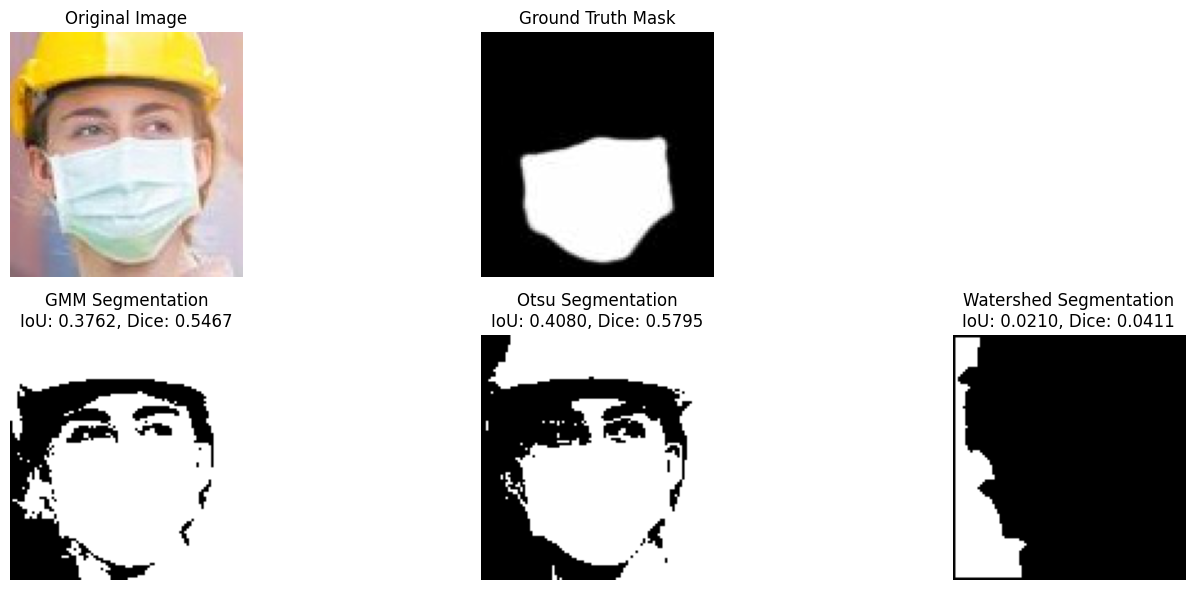

In [26]:
directory = "../dataset/face_crop"
groundTruth = "../dataset/face_crop_segmentation"

dice_gmm_list = []
dice_otsu_list = []
dice_watershed_list = []
iou_gmm_list = []
iou_otsu_list = []
iou_watershed_list = []

for filename in selected_images:
    # filename='004531_1.jpg'
    image_path = os.path.join(directory, filename)
    gt_path = os.path.join(groundTruth, filename)

    image = cv2.imread(image_path)
    if image is None:
        print("Image not found or unable to load.")
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ground_truth = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        
        mask_gmm = segment_gmm(image)
        mask_otsu = segment_otsu(image)
        mask_watershed = segment_watershed(image)
        iou_gmm, dice_gmm = compute_metrics(mask_gmm, ground_truth)
        iou_otsu, dice_otsu = compute_metrics(mask_otsu, ground_truth)
        iou_watershed, dice_watershed = compute_metrics(mask_watershed, ground_truth)

        dice_gmm_list.append(dice_gmm)
        dice_otsu_list.append(dice_otsu)
        dice_watershed_list.append(dice_watershed)
        iou_gmm_list.append(iou_gmm)
        iou_otsu_list.append(iou_otsu)
        iou_watershed_list.append(iou_watershed)
        # Display Results
        plt.figure(figsize=(15, 6))

        plt.subplot(2, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(2, 3, 2)
        plt.imshow(ground_truth, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(2, 3, 4)
        plt.imshow(mask_gmm, cmap="gray")
        plt.title(f"GMM Segmentation\nIoU: {iou_gmm:.4f}, Dice: {dice_gmm:.4f}")
        plt.axis("off")

        plt.subplot(2, 3, 5)
        plt.imshow(mask_otsu, cmap="gray")
        plt.title(f"Otsu Segmentation\nIoU: {iou_otsu:.4f}, Dice: {dice_otsu:.4f}")
        plt.axis("off")

        plt.subplot(2, 3, 6)
        plt.imshow(mask_watershed, cmap="gray")
        plt.title(f"Watershed Segmentation\nIoU: {iou_watershed:.4f}, Dice: {dice_watershed:.4f}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
    # break



In [27]:
print("IOU GMM Average: ", np.mean(iou_gmm_list))
print("DICE GMM Average: ", np.mean(dice_gmm_list))

IOU GMM Average:  0.41442576255577357
DICE GMM Average:  0.5405828395488503


In [28]:
print("IOU Otsu Average: ", np.mean(iou_otsu_list))
print("DICE Otsu Average: ", np.mean(dice_otsu_list))

IOU Otsu Average:  0.41370124234637257
DICE Otsu Average:  0.5405504366246416


In [29]:
print("IOU Watershed Average: ", np.mean(iou_watershed_list))
print("DICE Watershed Average: ", np.mean(dice_watershed_list))

IOU Watershed Average:  0.18651635192687738
DICE Watershed Average:  0.2278146728916218


In [31]:
sum_iou=0
sum_dice=0
for i in range(len(iou_gmm_list)):
    sum_iou+=max(iou_gmm_list[i],iou_otsu_list[i],iou_watershed_list[i])
    sum_dice+=max(dice_gmm_list[i],dice_otsu_list[i],dice_watershed_list[i])

print("Best IOU Average: ", sum_iou/len(iou_gmm_list))
print("Best DICE Average: ", sum_dice/len(dice_gmm_list))

Best IOU Average:  0.5814891861735471
Best DICE Average:  0.7267141696306888
